In [1]:
import numpy as np
import pandas as pd
import matplotlib #
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn #
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix
from sklearn.model_selection import KFold

import mlflow
import mlflow.sklearn

print("Numpy: {}".format(np.__version__))
print("Pandas: {}".format(pd.__version__))
print("matplotlib: {}".format(matplotlib.__version__))
print("seaborn: {}".format(sns.__version__))
print("Scikit-Learn: {}".format(sklearn.__version__))
print("MLFlow: {}".format(mlflow.__version__))

Numpy: 1.21.2
Pandas: 1.3.3
matplotlib: 3.4.3
seaborn: 0.11.2
Scikit-Learn: 0.24.2
MLFlow: 1.21.0


In [2]:
data_path = "data/creditcard.csv"

df = pd.read_csv(data_path)
df = df.drop("Time", axis=1)

In [3]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
normal = df[df.Class == 0].sample(frac=0.5,random_state=2020).reset_index(drop=True)
anomaly = df[df.Class == 1]

In [5]:
print(f"Normal: {normal.shape}")
print(f"Anomaly: {anomaly.shape}")

Normal: (142158, 30)
Anomaly: (492, 30)


In [6]:
normal_train, normal_test = train_test_split(normal, test_size = 0.2, random_state = 2020)
anomaly_train, anomaly_test = train_test_split(anomaly, test_size = 0.2, random_state = 2020)

normal_train, normal_validate = train_test_split(normal_train, test_size = 0.25, random_state = 2020)
anomaly_train, anomaly_validate = train_test_split(anomaly_train, test_size = 0.25, random_state = 2020)

In [7]:
x_train = pd.concat((normal_train,anomaly_train))
x_test = pd.concat((normal_test,anomaly_test))
x_validate = pd.concat((normal_validate,anomaly_validate))

y_train = np.array(x_train["Class"])
y_test = np.array(x_test["Class"])
y_validate = np.array(x_validate["Class"])

x_train = x_train.drop("Class", axis=1)
x_test = x_test.drop("Class", axis=1)
x_validate = x_validate.drop("Class", axis=1)

In [8]:
print("Training sets:\nx_train: {} \ny_train: {}".format(x_train.shape, y_train.shape))
print("\nTesting sets:\nx_test: {} \ny_test: {}".format(x_test.shape, y_test.shape))
print("\nValidation sets:\nx_validate {} \ny_validate: {}".format(x_validate.shape, y_validate.shape))

Training sets:
x_train: (85588, 29) 
y_train: (85588,)

Testing sets:
x_test: (28531, 29) 
y_test: (28531,)

Validation sets:
x_validate (28531, 29) 
y_validate: (28531,)


In [9]:
scaler = StandardScaler()
scaler.fit(pd.concat((normal,anomaly)).drop("Class",axis=1))

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_validate = scaler.transform(x_validate)

In [10]:
def train(sk_model, x_train, y_train):
    sk_model = sk_model.fit(x_train, y_train)
    
    train_acc = sk_model.score(x_train, y_train)
    mlflow.log_metric("train_acc", train_acc)
    
    print(f"Train Accuracy: {train_acc:.3%}")

In [11]:
def evaluate(sk_model, x_test, y_test):
    
    eval_acc = sk_model.score(x_test, y_test)
    
    preds = sk_model.predict(x_test)
    auc_score = roc_auc_score(y_test, preds)
    
    mlflow.log_metric("eval_acc", eval_acc)
    mlflow.log_metric("auc_score", auc_score)
    
    print(f"Auc Score: {auc_score:.3%}")
    print(f"Eval Accuracy: {eval_acc:.3%}")
    
    roc_plot = plot_roc_curve(sk_model, x_test, y_test, name='Scikit-learn ROC Curve')
    plt.savefig("sklearn_roc_plot.png")
    plt.show()
    plt.clf()
    
    conf_matrix = confusion_matrix(y_test,preds)
    ax = sns.heatmap(conf_matrix, annot=True, fmt='g')
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title("Confusion Matrix")
    plt.savefig("sklearn_conf_matrix.png")
    
    mlflow.log_artifact("sklearn_roc_plot.png")
    mlflow.log_artifact("sklearn_conf_matrix.png")

Train Accuracy: 99.893%
Auc Score: 85.341%
Eval Accuracy: 99.874%


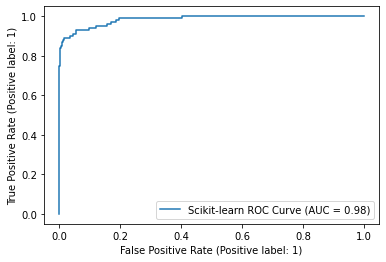

Model run:  cccae0309c1a4efe9fabf792f2bec895


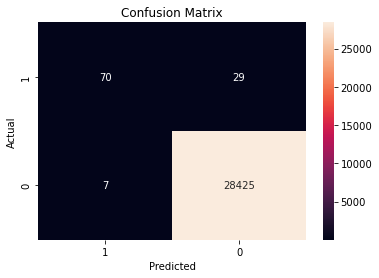

In [12]:
sk_model = LogisticRegression(random_state=None,max_iter=400,solver='newton-cg')

mlflow.set_experiment("scikit_learn_experiment")
with mlflow.start_run():
    train(sk_model, x_train, y_train)
    evaluate(sk_model, x_test, y_test)
    mlflow.sklearn.log_model(sk_model, "log_reg_model")
    print("Model run: ", mlflow.active_run().info.run_uuid)
mlflow.end_run() 

In [13]:
loaded_model = mlflow.sklearn.load_model("runs:/10273bfd43124a54a23835dcf1695af4/log_reg_model")

In [14]:
loaded_model.score(x_test,y_test)

0.9987382145736217

In [17]:
#anomaly_weights = [1,5,10,15]
anomaly_weights = [10, 50, 100, 150, 200]
num_folds = 5
kfold = KFold(n_splits=num_folds,shuffle=True,random_state=2020)

In [18]:
mlflow.set_experiment("sklearn_creditcard_guided_search")
logs = []
for f in range(len(anomaly_weights)):
    fold = 1
    accuracies = []
    auc_scores = []
    for train, test in kfold.split(x_validate, y_validate):
        with mlflow.start_run():
            weight = anomaly_weights[f]
            mlflow.log_param("anomaly_weight",weight)
            
            class_weights = {
                0: 1,
                1: weight
            }
            sk_model = LogisticRegression(random_state=None,max_iter=400,solver='newton-cg',
                                          class_weight=class_weights).fit(x_validate[train],y_validate[train])
            
            for h in range(40): print('-',end="")
            print(f"\nfold {fold}\nAnomaly Weight: {weight}")
            
            train_acc = sk_model.score(x_validate[train],y_validate[train])
            mlflow.log_metric("train_acc",train_acc)
            
            eval_acc = sk_model.score(x_validate[test],y_validate[test])
            preds = sk_model.predict(x_validate[test])
            mlflow.log_metric("eval_acc",eval_acc)
            
            try:
                auc_score = roc_auc_score(y_validate[test],preds)
            except:
                auc_score = -1
                
            mlflow.log_metric("auc_score",auc_score)
            
            print("AUC: {}\neval_acc: {}".format(auc_score,eval_acc))
            
            accuracies.append(eval_acc)
            auc_scores.append(auc_score)
            
            log = [sk_model,x_validate[test],y_validate[test],preds]
            logs.append(log)
            mlflow.sklearn.log_model(sk_model,f"anom_weight_{weight}_fold_{fold}")
            
            fold = fold + 1
            mlflow.end_run()
            
        print("\nAverages: ")
        print("Accuracy: ", np.mean(accuracies))
        print("AUC: ",np.mean(auc_scores))
        
        print("Best: ")
        print("Accuracy: ", np.max(accuracies))
        print("AUC: ", np.max(auc_scores))
                    

INFO: 'sklearn_creditcard_guided_search' does not exist. Creating a new experiment
----------------------------------------
fold 1
Anomaly Weight: 10
AUC: 0.9243845612801126
eval_acc: 0.9982477659015244

Averages: 
Accuracy:  0.9982477659015244
AUC:  0.9243845612801126
Best: 
Accuracy:  0.9982477659015244
AUC:  0.9243845612801126
----------------------------------------
fold 2
Anomaly Weight: 10
AUC: 0.9753109687146626
eval_acc: 0.9980722046968104

Averages: 
Accuracy:  0.9981599852991674
AUC:  0.9498477649973875
Best: 
Accuracy:  0.9982477659015244
AUC:  0.9753109687146626
----------------------------------------
fold 3
Anomaly Weight: 10
AUC: 0.9313783507133262
eval_acc: 0.9985979670522257

Averages: 
Accuracy:  0.9983059792168535
AUC:  0.943691293569367
Best: 
Accuracy:  0.9985979670522257
AUC:  0.9753109687146626
----------------------------------------
fold 4
Anomaly Weight: 10
AUC: 0.8943851628367561
eval_acc: 0.9985979670522257

Averages: 
Accuracy:  0.9983789761756965
AUC:  0.9